In [ ]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [ ]:
import os
import re
import io
import ast
import sys
import json
import boto3
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [ ]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [236]:
projName = "mlve"
experiment = "gestalt_shapegen"
experimentName = f"{experiment}-surface-normals"
S3_BUCKET_NAME = "mlve-v1"

attention_check = "attentionCheck"
batch_idx = "batchIdx"

To download data (@Yoni only), run: 
ssh -i ~/.aws/cocosci_ec2.pem -NL 8000:localhost:27017  ubuntu@ec2-3-90-78-57.compute-1.amazonaws.com

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [237]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [238]:
db.list_collection_names()

['hypersim_v2-depth-estimation-pilot',
 'hypersim_v3-segmentation-split-half',
 'hypersim_v3-depth-estimation-split-half',
 'tdw-segmentation-split-half',
 'gestalt_shapegen_object-loc',
 'tdw-surface-normals-split-half',
 'hypersim_v3-surface-normals',
 'nsd_surface-normals',
 'gestalt_shapegen-segmentation-split-half',
 'nsd-object-loc-split-half',
 'gestalt_video-object-loc',
 'gestalt_shapegen-depth-estimation-pilot',
 'nsd-surface-normals',
 'gestalt_shapegen_video-object-loc',
 'hypersim_surface-normals-splithalf',
 'tdw_surface-normals',
 'nsd-depth-estimation-pilot',
 'gestalt_shapegen-depth-estimation-split-half',
 'hypersim_surface-normals',
 'gestalt_shapegen-surface-normals',
 'gestalt_shapegen-surface-normals-split-half',
 'tdw-depth-estimation-pilot',
 'gestalt_object-loc',
 'tdw-depth-estimation-split-half']

In [239]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13827 entries, 0 to 13826
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             13827 non-null  object 
 1   imageMetadata                   13086 non-null  object 
 2   imageURL                        13728 non-null  object 
 3   trialType                       13728 non-null  object 
 4   trueArrowDirection              13728 non-null  object 
 5   isDuplicate                     13728 non-null  object 
 6   arrowPosition                   13728 non-null  object 
 7   arrowPixelPosition              13728 non-null  object 
 8   randomizeArrowInitialDirection  13728 non-null  object 
 9   attentionCheck                  13728 non-null  object 
 10  batchIdx                        13728 non-null  float64
 11  confidence                      0 non-null      float64
 12  indicatorFinalDirection         

In [241]:
iterNames = ["large-scale-v1"]
# df = df.query(f"iterationName in {iterNames}")

In [242]:
df.head()

,_id,imageMetadata,imageURL,trialType,trueArrowDirection,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,...,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID,rt,response
0,63570ab24dcbdfadeb1f84e0,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[0.11571044453374373, 0.8542877914555779, 0.50...",False,"[2.5349510763209393, 0.13025440313111591, 0]","[382, 262]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
1,63570abb4dcbdfadeb1f84e5,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[0.031671734280034496, 0.9934098864642448, 0.1...",False,"[-2.6551859099804305, 0.7113894324853227, 0]","[123, 291]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
2,63570ac34dcbdfadeb1f84ea,NaN,https://mlve-v1.s3.us-east-2.amazonaws.com/att...,unsupervised,"[0.020315807134660982, 0.944555875035678, 0.32...",False,"[-0.31060665362035245, -2.9557729941291586, 0]","[108, 240]",True,True,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
3,63570acb4dcbdfadeb1f84ee,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.25124952292676345, 0.6129654578362617, 0.7...",True,"[-1.6933072407045011, -2.5750293542074365, 0]","[171, 127]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
4,63570ad84dcbdfadeb1f84f5,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.5724818411799739, 0.715926089589965, 0.399...",True,"[3.2363209393346386, -3.276399217221135, 0]","[417, 92]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN


In [243]:
for i, x in df[df["trial_type"] == "survey-text"].iterrows():
    if x["response"]["participantComments"] or x["response"]["TechnicalDifficultiesFreeResp"]:
        print(x["response"])

{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'Thank you! '}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'Was very fun but pretty difficult as well.'}
{'TechnicalDifficultiesFreeResp': 'I did not encounter any difficulties', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': 'I did not encounter any diffivulties.', 'participantComments': 'I had a lot of fun!'}
{'TechnicalDifficultiesFreeResp': ' ', 'participantComments': 'It was challenging but fun'}
{'TechnicalDifficultiesFreeResp': 'n/a', 'participantComments': 'n/a'}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'Were the other two macaques not enjoying themselves?'}
{'TechnicalDifficultiesFreeResp': 'N/A', 'participantComments': 'A very interesting study!'}
{'TechnicalDifficultiesFreeResp': 'I did not encounter any technical difficulties.', 'participantComments': 'Very hard and abstract :( but interesting '}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'It was

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13827 entries, 0 to 13826
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             13827 non-null  object 
 1   imageMetadata                   13086 non-null  object 
 2   imageURL                        13728 non-null  object 
 3   trialType                       13728 non-null  object 
 4   trueArrowDirection              13728 non-null  object 
 5   isDuplicate                     13728 non-null  object 
 6   arrowPosition                   13728 non-null  object 
 7   arrowPixelPosition              13728 non-null  object 
 8   randomizeArrowInitialDirection  13728 non-null  object 
 9   attentionCheck                  13728 non-null  object 
 10  batchIdx                        13728 non-null  float64
 11  confidence                      0 non-null      float64
 12  indicatorFinalDirection         

In [245]:
df.head()

,_id,imageMetadata,imageURL,trialType,trueArrowDirection,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,...,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID,rt,response
0,63570ab24dcbdfadeb1f84e0,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[0.11571044453374373, 0.8542877914555779, 0.50...",False,"[2.5349510763209393, 0.13025440313111591, 0]","[382, 262]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
1,63570abb4dcbdfadeb1f84e5,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[0.031671734280034496, 0.9934098864642448, 0.1...",False,"[-2.6551859099804305, 0.7113894324853227, 0]","[123, 291]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
2,63570ac34dcbdfadeb1f84ea,NaN,https://mlve-v1.s3.us-east-2.amazonaws.com/att...,unsupervised,"[0.020315807134660982, 0.944555875035678, 0.32...",False,"[-0.31060665362035245, -2.9557729941291586, 0]","[108, 240]",True,True,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
3,63570acb4dcbdfadeb1f84ee,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.25124952292676345, 0.6129654578362617, 0.7...",True,"[-1.6933072407045011, -2.5750293542074365, 0]","[171, 127]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN
4,63570ad84dcbdfadeb1f84f5,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.5724818411799739, 0.715926089589965, 0.399...",True,"[3.2363209393346386, -3.276399217221135, 0]","[417, 92]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,None,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,NaN,NaN


In [246]:
df.drop("trial_type", axis=1, inplace=True)
df.drop("rt", axis=1, inplace=True)
df.drop("response", axis=1, inplace=True)
df.drop("inputid", axis=1, inplace=True)

In [247]:
df.drop(df[df["indicatorFinalDirection"].isna() == True].index, inplace=True)

In [248]:
df.drop(df[df["trueArrowDirection"].apply(lambda x: x == [None, None, None]) == True].index, inplace=True)

In [249]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [250]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [251]:
def draw_circles(ax, locs, size=10, edgecolor="red", facecolor="none", lw=2):
    """
    draws circle patches on an image at specified locations
    """
    for point in locs:
        circ = patches.Circle((point[1], point[0]), size, ec=edgecolor, fc=facecolor, lw=lw)
        ax.add_patch(circ)
    return ax


In [252]:
def cos_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [253]:
def geodesic_dist(a, b):
    a = np.array(a)
    b = np.array(b)
    if not a.shape or not b.shape:
        print("No data for: ", a, b)
        return float("nan")

    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    dist = np.arccos(a.dot(b))
    return dist

### Check user consistency

In [254]:
potential_fails = []
for user, rows in df.groupby("userID"):
    attention_checks = rows[rows[attention_check]]
    ifd = attention_checks["indicatorFinalDirection"].values
    tad = attention_checks["trueArrowDirection"].values
    
    dists = [geodesic_dist(a, b) for a, b in zip(ifd, tad)]
    score = np.mean(dists)
    if score > 1:
        print(user, score)
        potential_fails.append(user)
print(potential_fails)

562563ceed6e5a000bc7f386 1.6626322639955478
5a4f6c4b5f741700018a79a8 1.1459631224452764
5a9b7272f05361000171feef 1.2782716469280855
5eeba783164680119f2e30c7 1.574975048314917
5fed6c9c0d786daf31f29f3d 1.4953249987879917
60eb81e023788423a6ea43f9 1.7107203263029689
6121bad52d83ea41d7f38bb0 1.8664146800393506
6144f7e2bf25aad25ae610a1 1.7989673683656715
['562563ceed6e5a000bc7f386', '5a4f6c4b5f741700018a79a8', '5a9b7272f05361000171feef', '5eeba783164680119f2e30c7', '5fed6c9c0d786daf31f29f3d', '60eb81e023788423a6ea43f9', '6121bad52d83ea41d7f38bb0', '6144f7e2bf25aad25ae610a1']


/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [255]:
def l2_distance(a, b):
    return np.mean((np.array(a) - np.array(b)) ** 2)

In [256]:
df["geodesic_distance"] = df.apply(lambda x: geodesic_dist(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["cosine_similarity"] = df.apply(lambda x: cos_similarity(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["l2_distance"] = df.apply(lambda x: l2_distance(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)

In [257]:
for user in potential_fails:
    print(df[df["userID"] == user]["geodesic_distance"].mean(), user)

1.2777233969766408 562563ceed6e5a000bc7f386
1.1553267222907897 5a4f6c4b5f741700018a79a8
1.2533860174517133 5a9b7272f05361000171feef
1.3832808291245189 5eeba783164680119f2e30c7
1.3503092318646823 5fed6c9c0d786daf31f29f3d
1.3625543479393247 60eb81e023788423a6ea43f9
1.5336915645019686 6121bad52d83ea41d7f38bb0
1.2169908549567203 6144f7e2bf25aad25ae610a1


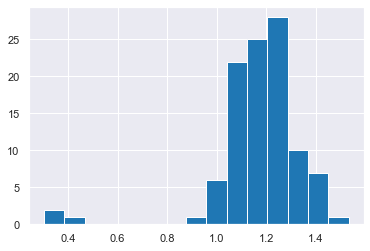

In [258]:
geo_errors = []
n_users = 0
for user, rows in df.groupby("imageURL"):
    geo_errors.append(rows["geodesic_distance"].mean())
    n_users += 1
    
plt.hist(geo_errors, bins=15)
plt.show()
    

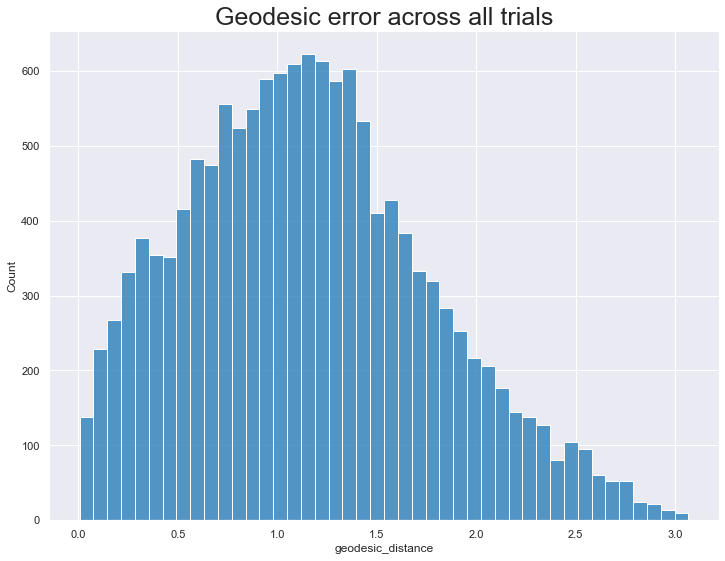

In [259]:

fig, axs = plt.subplots(1, 1, figsize=(12,9))
sns.histplot(df["geodesic_distance"], ax=axs)
# sns.histplot(df["cosine_similarity"], ax=axs[1])

axs.set_title(f"Geodesic error across all trials", fontsize=25)
# axs[1].set_title(f"Cosine similarity across all trials", fontsize=25)
# plt.suptitle(f"{experimentName}")

plt.show()

# Generate cleaned version

In [260]:
df.head()

,_id,imageMetadata,imageURL,trialType,trueArrowDirection,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,...,gameid,iterationName,projName,expName,sessionID,studyID,userID,geodesic_distance,cosine_similarity,l2_distance
0,63570ab24dcbdfadeb1f84e0,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[0.11571044453374373, 0.8542877914555779, 0.50...",False,"[2.5349510763209393, 0.13025440313111591, 0]","[382, 262]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,2.258424,-0.634706,1.089804
1,63570abb4dcbdfadeb1f84e5,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[0.031671734280034496, 0.9934098864642448, 0.1...",False,"[-2.6551859099804305, 0.7113894324853227, 0]","[123, 291]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,0.782223,0.709349,0.193768
2,63570ac34dcbdfadeb1f84ea,NaN,https://mlve-v1.s3.us-east-2.amazonaws.com/att...,unsupervised,"[0.020315807134660982, 0.944555875035678, 0.32...",False,"[-0.31060665362035245, -2.9557729941291586, 0]","[108, 240]",True,True,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,0.091089,0.995854,0.002764
3,63570acb4dcbdfadeb1f84ee,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.25124952292676345, 0.6129654578362617, 0.7...",True,"[-1.6933072407045011, -2.5750293542074365, 0]","[171, 127]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,1.990260,-0.407271,0.938181
4,63570ad84dcbdfadeb1f84f5,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.5724818411799739, 0.715926089589965, 0.399...",True,"[3.2363209393346386, -3.276399217221135, 0]","[417, 92]",True,False,...,4184-2b1b3385-5420-47bb-8c68-fd4447444d6e,large-scale-v1,mlve,gestalt_shapegen-surface-normals,635709bf88a1bfcc1b69ebc5,6357009711eb8b2b2f6b31df,623a5bb1b15d26b9c926a90b,0.532907,0.861334,0.092444


In [261]:
participants = df.groupby("userID")
participants_failed = []
i = 0 
batch_idxs = []
for index, user_results in participants:
    i += 1
    batch_idxs.append(user_results.iloc[0][batch_idx])
    
    if len(user_results) < 100:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not finish the experiment")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    if user_results["geodesic_distance"].mean() > 1.5:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not do too well")
        continue
        
    attention_checks = user_results[user_results[attention_check]] == True
    attention_score = attention_checks["geodesic_distance"].mean()
    if attention_score > 1:
        print("USER ID: " + user_results["userID"].iloc[0] + "scored: " + attention_score)
        participants_failed.append(user_results["userID"].iloc[0])

print(participants_failed)

# failed_participants = df["userID"].apply(lambda x: x in participants_failed)
# df = df[~failed_participants]
# attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
# df = df[~attention_checks]

# my_data = df["userID"] == "yoni_test2"
# df = df[~my_data]

USER ID: 56a93cf24020250005d62f2b did not finish the experiment
USER ID: 58578946c41fd90001434680 did not finish the experiment
USER ID: 5a8ac2d8f49c9a0001f3ab34 did not do too well
USER ID: 5cce948c6e2d5800183ede3c did not finish the experiment
USER ID: 5dee896cf87f5552d3cd6502 did not finish the experiment
USER ID: 5e8d44819163b611f62d706c did not do too well
USER ID: 5eea5fdcac5bc114627bdd67 did not do too well
USER ID: 5f4348be761e0a593fde3875 did not finish the experiment
USER ID: 6019e00ed94edf15326f30f3 did not finish the experiment
USER ID: 6121bad52d83ea41d7f38bb0 did not do too well
USER ID: 628bbe2c0f8080e6985e8592 did not do too well
USER ID: 629e126adbf299dacd5c878e did not do too well
['56a93cf24020250005d62f2b', '58578946c41fd90001434680', '5cce948c6e2d5800183ede3c', '5dee896cf87f5552d3cd6502', '5f4348be761e0a593fde3875', '6019e00ed94edf15326f30f3']


In [262]:
attention_indexes = df[df[attention_check] == True].index
df.drop(attention_indexes, axis=0, inplace=True)

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13086 entries, 0 to 13825
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             13086 non-null  object 
 1   imageMetadata                   13086 non-null  object 
 2   imageURL                        13086 non-null  object 
 3   trialType                       13086 non-null  object 
 4   trueArrowDirection              13086 non-null  object 
 5   isDuplicate                     13086 non-null  object 
 6   arrowPosition                   13086 non-null  object 
 7   arrowPixelPosition              13086 non-null  object 
 8   randomizeArrowInitialDirection  13086 non-null  object 
 9   attentionCheck                  13086 non-null  object 
 10  batchIdx                        13086 non-null  float64
 11  confidence                      0 non-null      float64
 12  indicatorFinalDirection         

# split half reliability

11
(100, 11, 3) trials to choose from


ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of ticklabels (13).

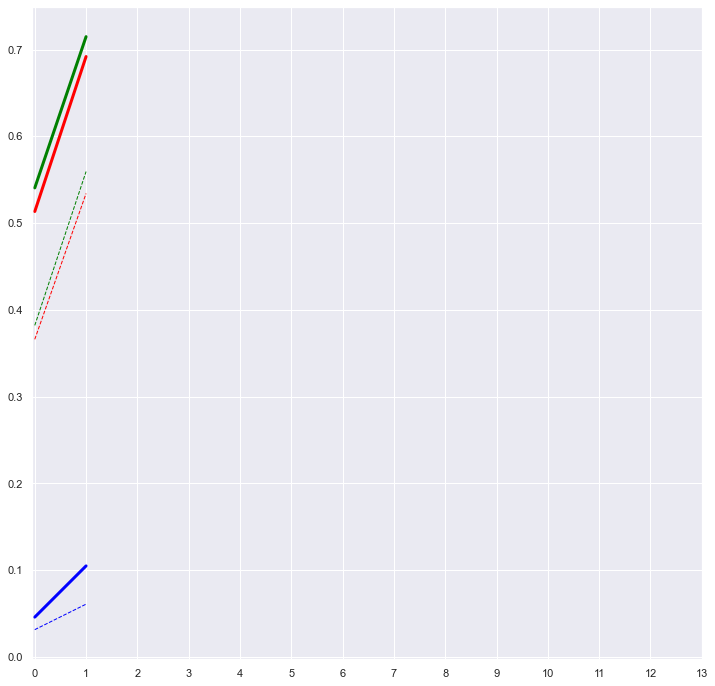

In [266]:
# Split data by user
# For each trial correlate half and half splits

# def calculate_splithalf(split_num, batchIdx=0):
"""
split_num: int: number of participants to sample for each half (ie; if split_num is 5, you choose 5 people for group A and 5 for group B)
"""


batchIdx = 0
def compute_split_half(batchIdx):
    splits = 1000
    batch_df = df.loc[df["batchIdx"] == batchIdx]

    # Build data table
    trials = [np.array(x[1].values) for x in batch_df.groupby("imageURL")["indicatorFinalDirection"]]
    data = []
    min_subs_per_point = np.min([x.shape[0] for x in trials])
    print(min_subs_per_point)
    for x in trials:
        if x.shape[0]>70:
            continue
        else:
            data.append([])
            for y in range(min_subs_per_point):
                data[-1].append(x[y])
    data = np.array(data)
    print(f"{data.shape} trials to choose from")

    # Take 1000 random splits of participants
    split_halfs = np.ndarray((splits, 3))
    n_subs_half = min_subs_per_point//2
    for i in range(splits):
        inds = np.random.choice(range(min_subs_per_point), min_subs_per_point, replace=False)
        vec0 = np.mean(data[:,inds[:n_subs_half],:], axis=1)
        vec1 = np.mean(data[:, inds[n_subs_half:], :], axis=1)
        for dim in range(3):
            split_halfs[i,dim] = np.corrcoef(vec1[:,dim], vec0[:,dim])[0][1]

    subs_per_split = np.arange(2,(min_subs_per_point // 2)+1,2)
    split_halfs_by_n = np.ndarray((len(subs_per_split), splits, 3))
    split_halfs_by_n_sb = np.ndarray((len(subs_per_split), splits, 3))
    for i0, n_subs_half in enumerate(subs_per_split):
        for i in range(splits):
            inds = np.random.choice(range(min_subs_per_point), int(n_subs_half*2), replace=False)
            vec0 = np.mean(data[:,inds[:n_subs_half],:], axis=1)
            vec1 = np.mean(data[:, inds[n_subs_half:], :], axis=1)
            for dim in range(3):
                stat = np.corrcoef(vec1[:,dim], vec0[:,dim])[0][1]
                split_halfs_by_n[i0, i, dim] = stat
                split_halfs_by_n_sb[i0, i, dim] = (2*stat) / (1+stat)

    
    return split_halfs_by_n, split_halfs_by_n_sb

batch_id = 0
split_halfs_by_n, split_halfs_by_n_sb = compute_split_half(batch_id)
fig = plt.figure(figsize=(12,12))
cs = ["r", "g", "b"]
dim = ["x", "y", "z"]
for i in range(3):
    plt.plot(np.mean(split_halfs_by_n, axis=1)[:, i], lw=1, c=cs[i], ls="--", label=dim[i])
    plt.plot(np.mean(split_halfs_by_n_sb, axis=1)[:, i], lw=3, c=cs[i], label=dim[i])

plt.xticks(range(min_subs_per_point // 2), 2*np.arange(2,min_subs_per_point,2))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.xlabel("# Participants")
plt.ylabel("Split Half Reliability")
plt.legend(by_label.values(), by_label.keys())
plt.title("Spearman Brown Corrected Split Half")
plt.suptitle(experimentName, y=0.95)
plt.show()



In [206]:
def plot_splithalf():
    fig = plt.figure(figsize=(12,8))
    batches_r = []
    batches_spb = [] 
    max_participants = 8
    split_nums = [x // 2 for x in range(2, max_participants + 1, 2)]
    batches = 8
    for b in range(batches):
        rs = []
        spbs = []
        for split_num in split_nums:    
            r, spb = calculate_splithalf(split_num, batchIdx=b)
            spbs.append(spb)
            rs.append(r)
        batches_r.append(rs)
        batches_spb.append(spbs)

    plt.yticks(fontsize=22)
    plt.xticks(split_nums, [n * 2 for n in split_nums], fontsize=22)
    batch_r = np.mean(batches_r, axis=0)
    batch_spb = np.mean(batches_spb, axis=0)
    print(batch_r.shape)

    plt.plot(split_nums, batch_r, lw=6, color="red", label="Pearson R")
    plt.plot(split_nums, batch_spb, lw=6, color="blue", label="Spearman-Brown Corrected")
    for b in range(batches):
        rs = batches_r[b]
        spbs = batches_spb[b]
        plt.plot(split_nums, rs, lw=3, alpha=0.25, color="red")
        plt.plot(split_nums, spbs, lw=3, alpha=0.25, color="blue")
        plt.xlabel("N Participants", fontsize=22)
        plt.ylabel("Reliability", fontsize=22)


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Split Half Reliability", fontsize=22)
    plt.suptitle(f"{experimentName}")
    plt.show()

# To-Do:

2. Check consistency
3. Rank participants by score
4. Check which trials had the lowest score

## Visualization Ideas

4. Each image w/ probe locations --> put em in a zip
3. Heatmap on a sphere?
1. Download image -- overlay subject estimates with arrow
6. Correlate (X, Y) with estimate + error
5. NSD --> Check participant distribution (histogram, heatmap)
7. Surface normal UNet / model?

### long shot vis
1. Compare distribution of histograms across datasets

## Plot the distribution of surface normals

In [305]:
indicator_directions = np.array([x for x in df["indicatorFinalDirection"]])
true_directions = np.array([x for x in df["trueArrowDirection"]])

In [306]:
### from tqdm.notebook import tqdm

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=geodesic_dist(p, pj)
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

def calculate_heatmap(pointList, threshold=0.5):

    u = np.linspace( 0, 2 * np.pi, 20)
    v = np.linspace( 0, np.pi, 20)

    # create the sphere surface
    XX = np.outer( np.cos( u ), np.sin( v ) )
    YY = np.outer( np.sin( u ), np.sin( v ) )
    ZZ = np.outer( np.ones( np.size( u ) ), np.cos( v ) )

    pbar = tqdm(total = len(XX) * len(XX[0]))

    WW = XX.copy()
    for i in range( len( XX ) ):
        for j in range( len( XX[0] ) ):
            x = XX[ i, j ]
            y = YY[ i, j ]
            z = ZZ[ i, j ]

            dist = near(np.array( [x, y, z ] ), pointList, threshold)
            WW[ i, j ] = dist
            pbar.update(1)

    heatmap = WW / np.amax( WW )
    return heatmap, (XX, YY, ZZ)

In [307]:
participant_heatmap, participant_coords = calculate_heatmap(indicator_directions)
if experimentName != "nsd_surface-normals":
    gt_heatmap, true_coords = calculate_heatmap(true_directions)

100%|████████████████████████████████████████████████████████| 400/400 [00:23<00:00, 16.94it/s]


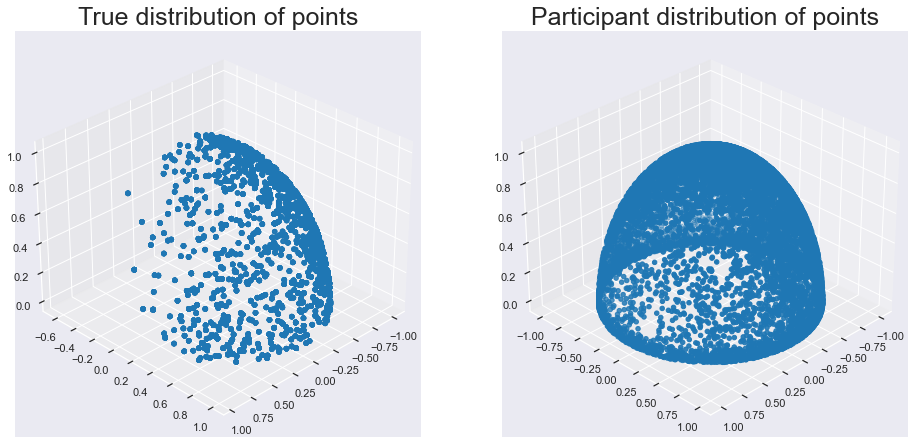

In [308]:
if experimentName != "nsd_surface-normals":

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot( 1, 2, 1, projection='3d')
    ax2 = fig.add_subplot( 1, 2, 2, projection='3d')

    ax1.set_title("True distribution of points", fontsize=25)
    ax2.set_title("Participant distribution of points", fontsize=25)
    ax1.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2])
    ax2.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2])

    angle = 45
    degrees = 30
    ax1.view_init(degrees, angle)
    ax2.view_init(degrees, angle)
else:
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot( 1, 1, 1, projection='3d')
    ax1.set_title("Participant distribution of points", fontsize=25)
    ax1.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2])


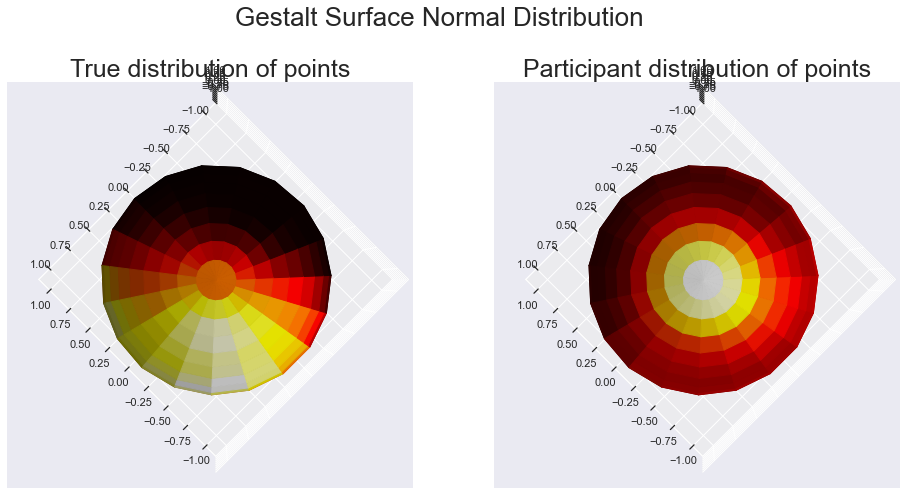

In [317]:
fig = plt.figure(figsize=(16,12))
if experimentName != "nsd_surface-normals":

    ax1 = fig.add_subplot( 1, 2, 1, projection='3d')
    ax2 = fig.add_subplot( 1, 2, 2, projection='3d')

    x, y, z = true_coords
    ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(gt_heatmap))

    x, y, z = participant_coords
    ax2.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(participant_heatmap))

    ax1.set_title("True distribution of points", fontsize=25)
    ax2.set_title("Participant distribution of points", fontsize=25)

    angle = 135
    degrees = 90
    ax1.view_init(degrees, angle)
    ax2.view_init(degrees, angle)

    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution", y=0.825)
    plt.show()
else: 
    ax1 = fig.add_subplot( 1, 1, 1, projection='3d')
    x, y, z = participant_coords
    ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(participant_heatmap))
    ax1.set_title("Participant distribution of points", fontsize=25)
    
    angle = 180
    degrees = 180
    ax1.view_init(degrees, angle)
    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution", y=0.95)
    plt.show()

Text(0.5, 0.98, 'gestalt_shapegen-surface-normals')

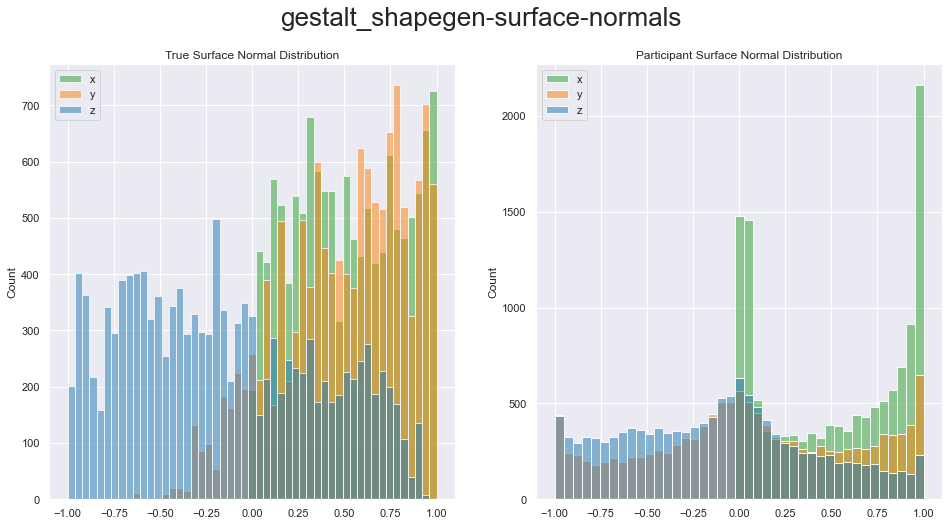

In [310]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
g = sns.histplot(true_directions, ax=axs[0])
axs[0].legend(["x","y","z"])
axs[0].set_title("True Surface Normal Distribution")

g = sns.histplot(indicator_directions, ax=axs[1])
axs[1].legend(["x","y","z"])
axs[1].set_title("Participant Surface Normal Distribution")
plt.suptitle(f"{experimentName}")

## Visualize the distribution of sampled points on images

In [311]:
plot_images = False

In [312]:
if plot_images:
    save_dir = os.path.join(f"figures/{experimentName}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sns.set_style("white")
    for url, row in df.groupby("imageURL"):
        point_locs = row["arrowPixelPosition"]
        locs = set()
        for point in point_locs:
            locs.add(tuple(point))

        locs = list(locs)
        image = download_from_url(url)
        plt.close()
        fig,ax = plt.subplots(1, figsize=(12, 12))
        ax.set_aspect('equal')

        ax = draw_circles(ax, locs, size=15, lw=4)
        ax = draw_circles(ax, locs, size=10, lw=4)

        ax.imshow(image)
    #     pixelPositions = row["arrowPixelPosition"]
    #     idfs = row["indicatorFinalDirection"]
    #     for i in range(len(pixelPositions)):
    #         loc = pixelPositions.iloc[i]
    #         ifd = idfs.iloc[i]
    #         r = lambda: np.random.randint(0,255)
    #         color = '#%02X%02X%02X' % (r(),r(),r())
    #         ax.quiver(loc[1], loc[0], ifd[0], ifd[2], scale=ifd[1], color=color, angles="xy", scale_units='y')

        save_title = url.split("/")[-1]
        plt.savefig(os.path.join(save_dir, save_title))
        plt.show()


    sns.set_style("darkgrid")   

In [313]:
indicator_directions.shape, heatmap.shape

NameError: name 'heatmap' is not defined

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=participant_heatmap.flatten(),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=3,
                                    color=gt_heatmap.flatten() + np.random.random(3600),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


In [ ]:
titles = ["x", "y", "z"]
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
for i in range(3):
    axs[i].scatter(indicator_directions[:, i], true_directions[:, i])
    axs[i].set_title(titles[i] + " direction correlation")
    print(np.corrcoef(indicator_directions[:, i], true_directions[:, i]))
    
    
plt.suptitle("Correlation to Ground truth - " + experimentName)
plt.show()


In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2], color="red", alpha=0.7)
ax.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2], color="blue")

plt.show()

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="blue",
                                    size=5,
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})
fig.show()

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="red",
                                    size=5,
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})



fig.show()


In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=true_directions[:, 0],                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( heatmap ) )
plt.show() 


In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=heatmap,                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

In [ ]:
x = np.linspace(-4, 4, 6)
y = np.linspace(-4, 4, 6)
X, Y = np.meshgrid(x, y)
U = X + Y
V = Y - X

# plot
fig, ax = plt.subplots()

ax.quiver(X, Y, U, V, color="C0", angles='xy',
          scale_units='xy', scale=5, width=.015)

ax.set(xlim=(-5, 5), ylim=(-5, 5))

plt.show()